In [51]:
# Importing Libraries
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import random

# Set User

In [55]:
# Generate synthetic user information for a specific user
user_info = {
    'gender': 'Female',
    'age': 22,  # You can adjust the age if needed
    'height': 162,
    'current_weight': 62,
    'target_weight': 55,
    'weeks_to_achieve': 10
}

# Initialize start date
start_date = '2024-03-01'


# Generate Run Data

In [56]:
# Function to generate synthetic data for a single run
def generate_run_data(duration_minutes, start_datetime):
    # Generate timestamps at 5-second intervals
    timestamps = pd.date_range(start=start_datetime, periods=duration_minutes * 12, freq='5s')

    # Generate initial random speed data with a more realistic range and variation
    speed_data = np.linspace(np.random.uniform(6, 8), np.random.uniform(12, 15), num=len(timestamps))
    speed_data += np.random.normal(scale=0.5, size=len(speed_data))

    # Apply a rolling mean to smoothen the speed pattern
    smooth_speed_data = pd.Series(speed_data).rolling(window=10, min_periods=1, center=True).mean().round(1)

    # Generate random inclination values (0 to 8)
    inclination_data = np.random.randint(0, 9, size=len(timestamps))

    return pd.DataFrame({'timestamp': timestamps, 'speed': smooth_speed_data, 'inclination': inclination_data})

# Generate 100 runs of synthetic data for the specific user
runs_data = []

for run_number in range(100):
    # Define run duration
    run_duration = random.randint(10, 20)

    # Generate random start time for each run
    start_datetime = pd.to_datetime(start_date) + pd.to_timedelta(random.randint(0, 1440), unit='m')

    # Generate data for the current run
    run_data = generate_run_data(run_duration, start_datetime)
    
    # Increment the start date for the next run
    start_date = (pd.to_datetime(start_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    # Add user information to each row
    run_data['gender'] = user_info['gender']
    run_data['age'] = user_info['age']
    run_data['height'] = user_info['height']
    run_data['current_weight'] = user_info['current_weight']
    run_data['target_weight'] = user_info['target_weight']
    run_data['weeks_to_achieve'] = user_info['weeks_to_achieve']

    runs_data.append(run_data)

# Concatenate the runs into a single DataFrame
full_data = pd.concat(runs_data, ignore_index=True)

# Save the synthetic data to a CSV file
full_data.to_csv('run_data_single_user_inclination.csv', index=False)


# Plot the run

            timestamp  speed  inclination  gender  age  height  \
0 2024-03-01 09:41:00    6.8            6  Female   22     162   
1 2024-03-01 09:41:05    6.8            3  Female   22     162   
2 2024-03-01 09:41:10    6.9            5  Female   22     162   
3 2024-03-01 09:41:15    6.9            4  Female   22     162   
4 2024-03-01 09:41:20    6.9            5  Female   22     162   

   current_weight  target_weight  weeks_to_achieve  
0              62             55                10  
1              62             55                10  
2              62             55                10  
3              62             55                10  
4              62             55                10  


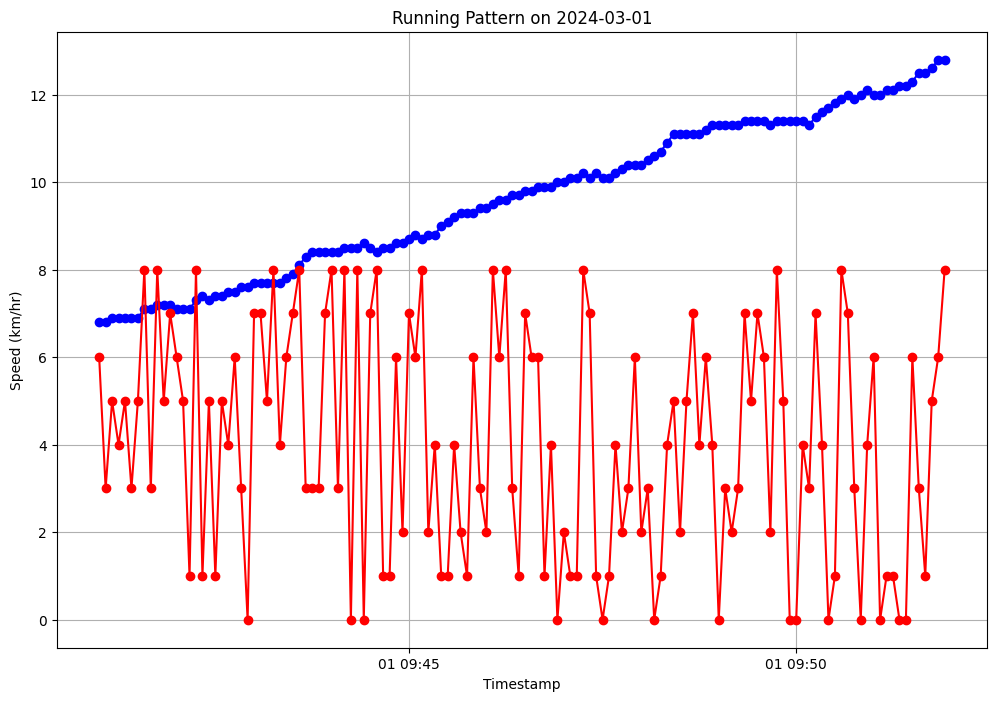

In [59]:
# Plotting the Run for a start_date
# Load the synthetic data with date
data = pd.read_csv('run_data_single_user_inclination.csv', parse_dates=['timestamp'])
print(data.head())

# Choose a specific date for plotting (change this to the desired date)
selected_date = '2024-03-01'

# Filter data for the selected date
selected_data = data[data['timestamp'].dt.date == pd.to_datetime(selected_date).date()]

# Plot speed for the selected day
plt.figure(figsize=(12, 8))
plt.plot(selected_data['timestamp'], selected_data['speed'], marker='o', linestyle='-', color='b')
plt.plot(selected_data['timestamp'], selected_data['inclination'], marker='o', linestyle='-', color='r')

plt.title(f'Running Pattern on {selected_date}')
plt.xlabel('Timestamp')
plt.ylabel('Speed (km/hr)')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the synthetic data with date
data = pd.read_csv('synth_run_data_single_user.csv', parse_dates=['timestamp'])

# Feature Engineering
data['hour_of_day'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month
data['time_of_day'] = pd.cut(data['hour_of_day'], bins=[0, 6, 12, 18, 24], labels=[0, 1, 2, 3])

# Running Metrics
data['average_speed'] = data.groupby('timestamp')['speed'].transform('mean')
data['max_speed'] = data.groupby('timestamp')['speed'].transform('max')
data['min_speed'] = data.groupby('timestamp')['speed'].transform('min')
data['speed_trend'] = data['speed'].rolling(window=10, min_periods=1).mean()

# Additional Derived Features
data['progress_towards_target'] = data['current_weight'] - data['target_weight']
data['speed_change'] = data['speed'].diff()

# Select relevant features for model training
features = ['age', 'height', 'current_weight', 'weeks_to_achieve', 'day_of_week', 'month', 'time_of_day', 'average_speed', 'max_speed', 'min_speed', 'speed_trend', 'progress_towards_target', 'speed_change']

# Drop unnecessary columns
data = data[features + ['speed']]  # Ensure target variable is included

# Print column names before one-hot encoding
print("Before one-hot encoding:", data.columns.tolist())

# Convert categorical features to numerical using one-hot encoding
# data = pd.get_dummies(data, columns='time_of_day', drop_first=True)

# Print column names after one-hot encoding
# print("After one-hot encoding:", data.columns.tolist())

# Split data into features and target variable
X = data[features]
y = data['speed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load your dataset (replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv('synth_run_data_single_user.csv')

# Assuming the dataset has columns 'timestamp' and 'speed'
# For simplicity, you might need to include other features based on your dataset

# Convert 'timestamp' to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Normalize the 'speed' column
scaler = MinMaxScaler()
df['speed_normalized'] = scaler.fit_transform(df[['speed']])

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length]['speed_normalized']
        target = data.iloc[i+sequence_length]['speed_normalized']
        sequences.append(seq.values)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (adjust based on your requirement)
sequence_length = 10

# Create sequences and targets
sequences, targets = create_sequences(df[['speed_normalized']], sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Reshape the data to fit the LSTM model input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Now, you can use the trained model to generate a new run based on the past data.
# You need to create a sequence similar to the training sequences and predict the next value.

# For simplicity, let's use the last sequence from the testing data to generate a new run
new_sequence = X_test[-1].reshape(1, sequence_length, 1)
predicted_speed_normalized = model.predict(new_sequence)

# Inverse transform to get the predicted speed in the original scale
predicted_speed = scaler.inverse_transform(predicted_speed_normalized.reshape(-1, 1))

# Print the predicted speed for the next time step
print("Predicted Speed for the Next Time Step:", predicted_speed[0, 0])


In [ ]:
# Initialize the initial sequence with the last sequence from the testing data
generated_sequence = X_test[-1].reshape(1, sequence_length, 1)

# Number of time steps to generate
num_time_steps = 100

# Initialize a list to store the generated speed values
generated_speed_values = []

# Generate the time series data
for _ in range(num_time_steps):
    # Predict the next speed value
    predicted_speed_normalized = model.predict(generated_sequence)
    
    # Inverse transform to get the predicted speed in the original scale
    predicted_speed = scaler.inverse_transform(predicted_speed_normalized.reshape(-1, 1))
    
    # Append the predicted speed to the generated sequence
    generated_sequence = np.append(generated_sequence[:, 1:, :], predicted_speed_normalized.reshape(1, 1, 1), axis=1)
    
    # Append the predicted speed to the list
    generated_speed_values.append(predicted_speed[0, 0])

# Create a time index for the generated time series
generated_time_index = pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=5), periods=num_time_steps, freq='5s')

# Create a DataFrame for the generated time series
generated_time_series = pd.DataFrame({'timestamp': generated_time_index, 'predicted_speed': generated_speed_values})


# Plot the generated time series
plt.figure(figsize=(12, 6))
plt.plot(generated_time_series['timestamp'], generated_time_series['predicted_speed'], label='Generated Time Series', color='red')
plt.title('Generated Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Speed (km/hr)')
plt.legend()
plt.show()


In [ ]:
print(generated_time_series)